# p-Hub problem



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Description" data-toc-modified-id="Problem-Description-1">Problem Description</a></span><ul class="toc-item"><li><span><a href="#p-Hub" data-toc-modified-id="p-Hub-1.1">p-Hub</a></span></li><li><span><a href="#Integer-programming-model:" data-toc-modified-id="Integer-programming-model:-1.2">Integer programming model:</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2">Setup</a></span></li><li><span><a href="#Example" data-toc-modified-id="Example-3">Example</a></span><ul class="toc-item"><li><span><a href="#Random-Data" data-toc-modified-id="Random-Data-3.1">Random Data</a></span></li><li><span><a href="#Road-Network-Data" data-toc-modified-id="Road-Network-Data-3.2">Road Network Data</a></span></li></ul></li></ul></div>

## Problem Description

###  p-Hub
*Parameters*:
* $N$:  Set of nodes
* $C_{ij}$: Distance from node $i \in N$ to node $j\in N$. It is assumed that $C_{ii} = 0 (i\in N)$ and that the distances satisty the triangle inequality collection
* $P^{C},P^{D},P^{T}$: Collection,Distribution and Transfer cost
* $W_{ij}$: Flow originated at node $i\in N$ that is destined to node $j\in N$
* $O_i=\sum_{j}W_{ij}$: Total flow originated at node $i\in N$
* $D_i=\sum_{j}W_{ji}$: Total flow destined to node $i\in N$
* $y_{ikh}$: Amount of flow originated at node $i \in N$ that is routed via hubs $k$ and $h$ in this order ($i,k,h\in N$)

*Decision variables*:
$$\begin{array}{lll}
x_{ik}= \begin{cases}1, & \text { if demand } i \text { is allocated to hub } k \\ 0, & \text { else }\end{cases}\\
\end{array}
$$


###  Integer programming model:
$$
\begin{array}{lll}
\text{min} & \sum_{ik}P^{C}C_{ik}O_{i}x_{ik}+\sum_{ikh}P^{T}C_{kh}y_{ikh}+\sum_{ik}P^{D}C_{ki}D_{i}x_{ik} & (1) \\
\text{s.t.} & \sum_{k}x_{ik}=1, \quad \forall i & (2) \\
& x_{ik}\leq x_{kk}, \quad \forall i,k & (3) \\
& \sum_{k}x_{kk}=H & (4) \\
& \sum_{h}y_{ikh}-\sum_{h}y_{ihk}=O_{i}x_{ik}-\sum_{j}W_{ij}x_{jk},\quad \forall i,k & (5) \\
& \sum_{h\neq k}y_{ikh}\leq O_{i}x_{ik},\quad \forall i,k & (6)\\
& x_{ik}\in \{0,1\} \quad \forall i,k & (7)\\
& y_{ikh}\geq 0 \quad \forall i,k,h & (8)\\
\end{array}
$$


## Setup

In [16]:
import random
from itertools import product
import numpy as np
import osmnx as ox
import pandas as pd

from location.PModel import *

In [17]:
np.random.seed(0) # random seed
random.seed(0)
solver_list = listSolvers(onlyAvailable=True)
print(solver_list)  

No parameters matching '_test' found
['CPLEX_CMD', 'GUROBI', 'GUROBI_CMD', 'PULP_CBC_CMD']


## Example

### Random Data

In [18]:
num_points = 10
num_hubs = 3
PC, PT, PD = 1.0, 0.75, 1.25
w = np.random.randint(1, 100, size=(num_points, num_points))
x = random.sample(range(100), num_points)
y = random.sample(range(100), num_points)
A, X, Y, P = PHub(num_points=num_points,
           num_hubs=num_hubs,
           collect_cost=PC,
           transfer_cost=PT,
           distribution_cost=PD,
           x_lat=x,
           y_lon=y,
           cover=w,
           solver=PULP_CBC_CMD()).prob_solve()

Status: Optimal
Selected hubs = [3, 4, 5]
Minimum total cost =  None
p-Hub 3:[0, 3, 8]
p-Hub 4:[2, 4, 6]
p-Hub 5:[1, 5, 7, 9]


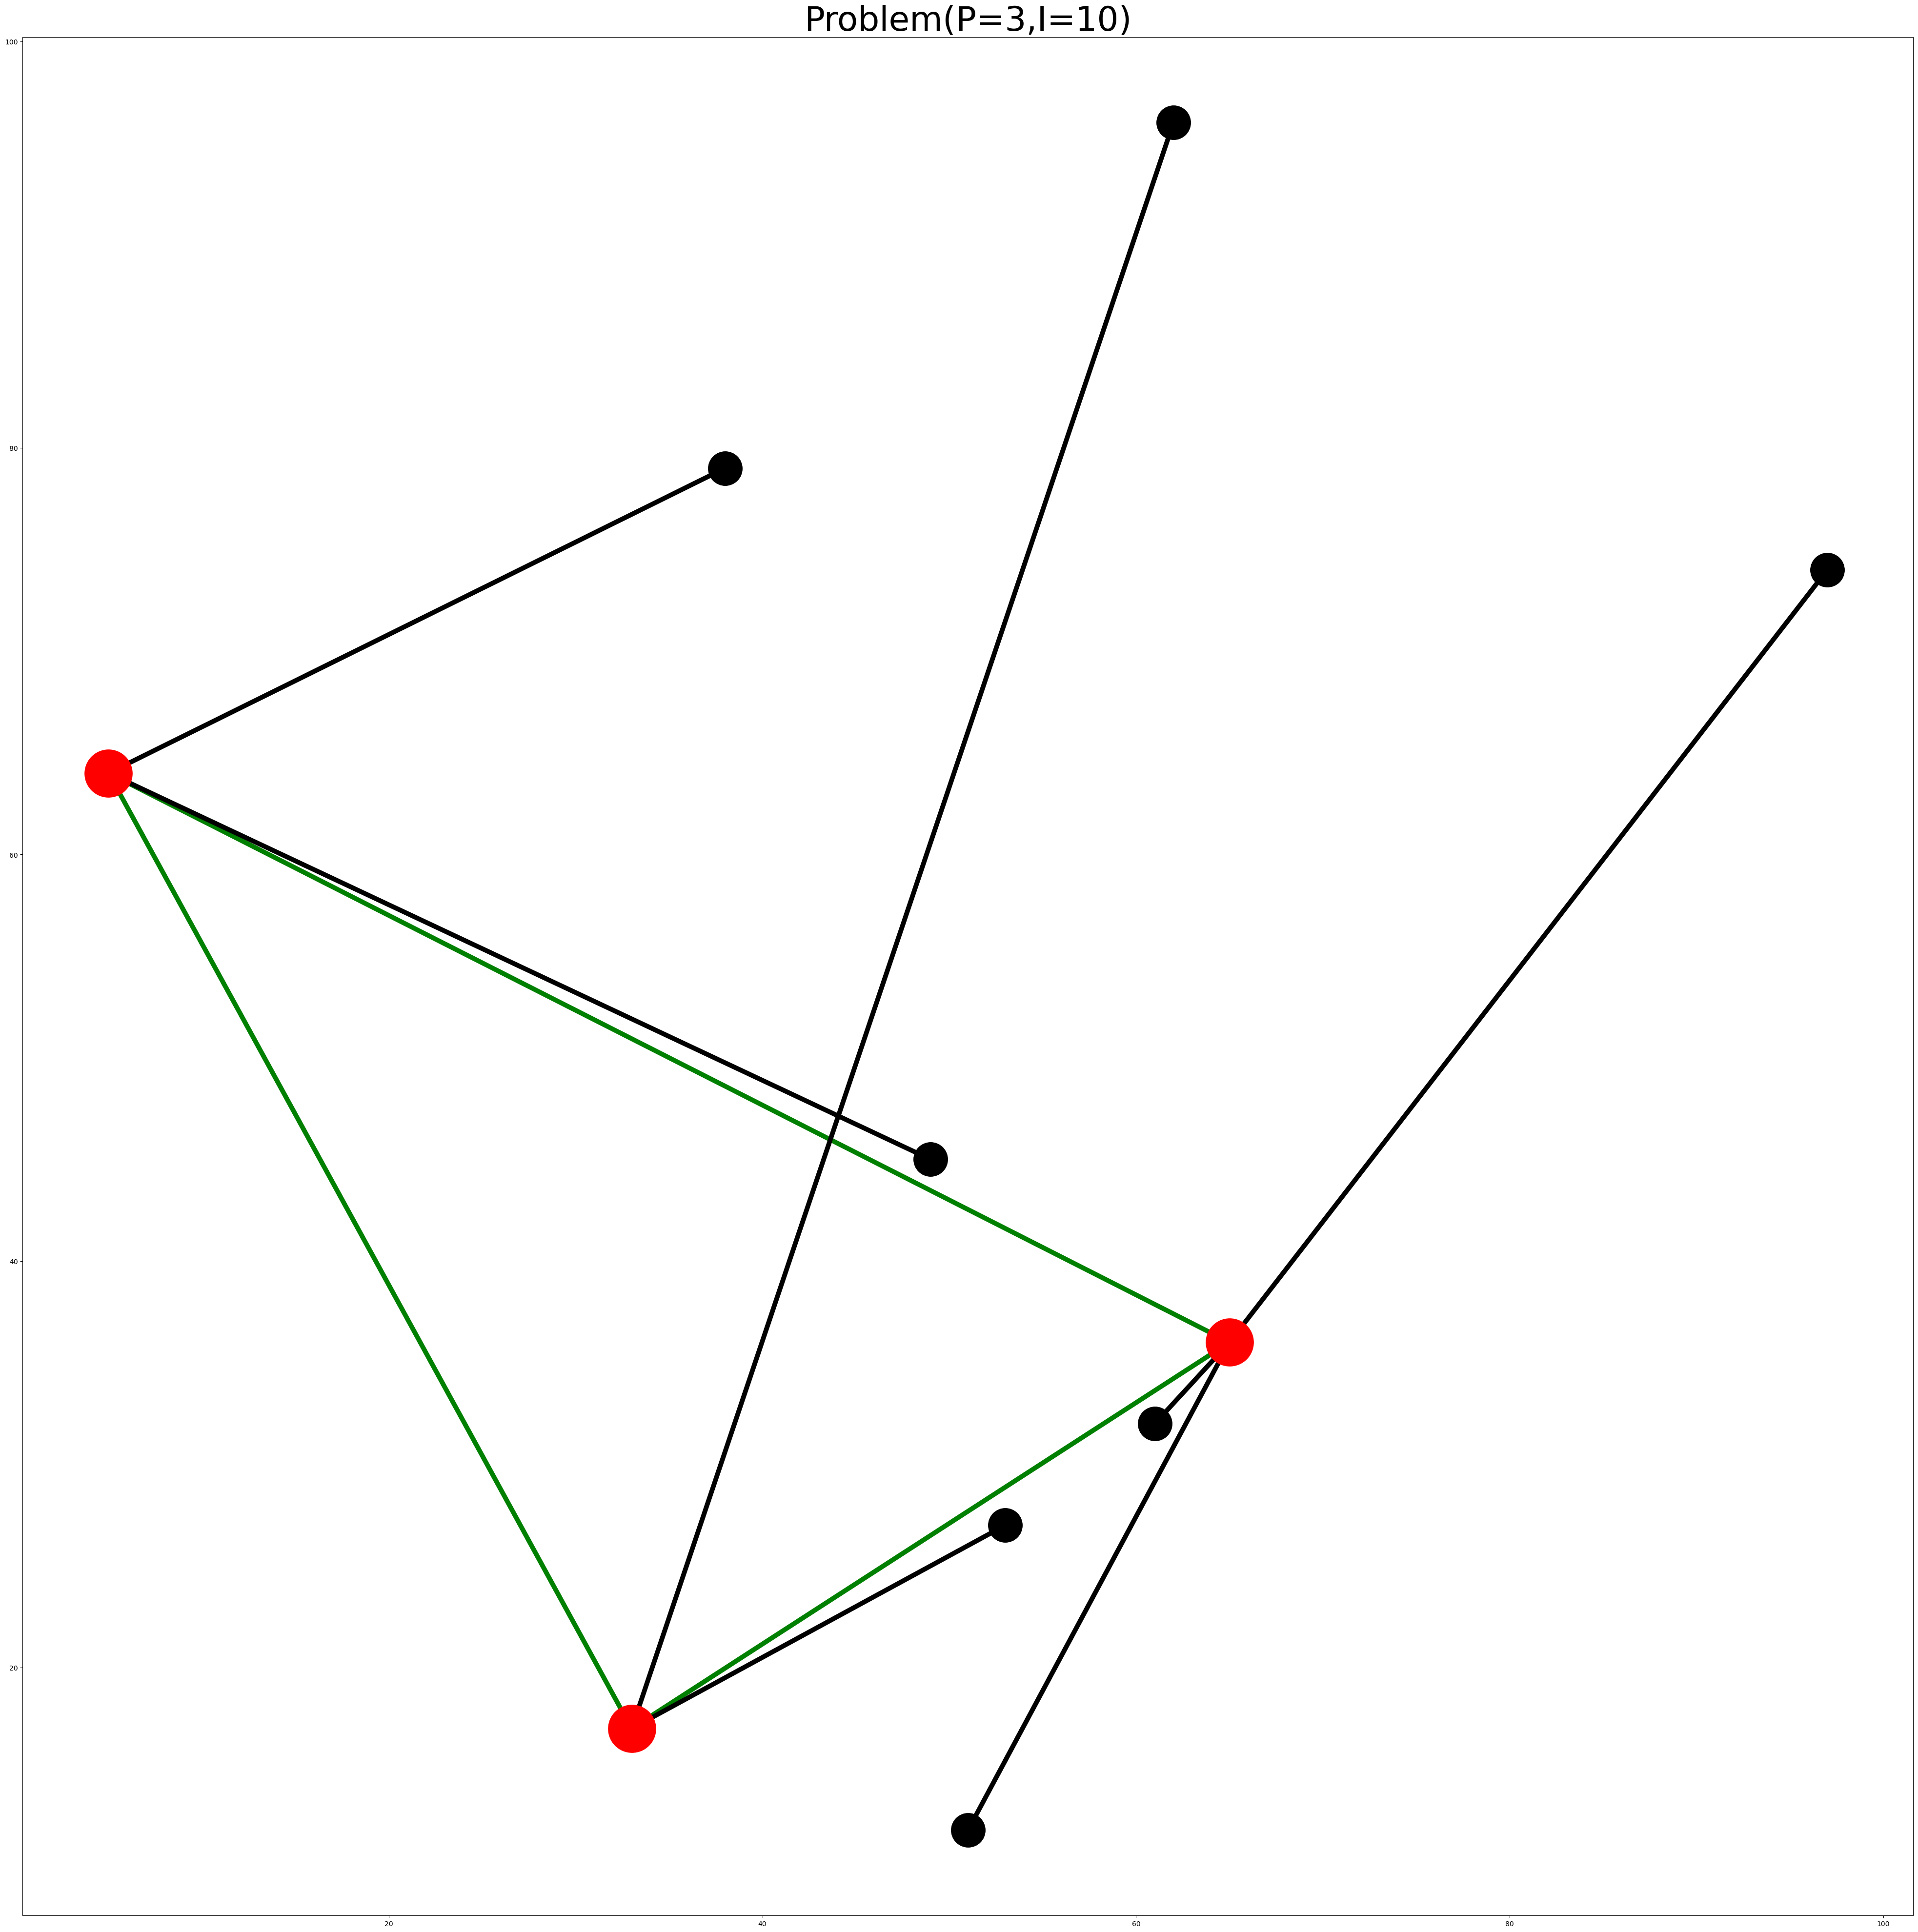

In [19]:
plt.figure(figsize=(50,50))
name = 'Problem(P=' + str(num_hubs) + ',I=' + str(num_points) + ')'
plt.title(name, fontsize = 50)
N = list(range(len(X)))
H = list(set(A))
for k1 in range(len(H)):
    for k2 in range(k1, len(H)):
        i = H[k1]
        j = H[k2]
        plt.plot([X[i], X[j]], [Y[i], Y[j]], color='g', linewidth=7)
for i in set(N) - set(H):
    plt.plot([X[i], X[A[i]]], [Y[i], Y[A[i]]], color='k', linewidth=7)
    plt.plot(X[i], Y[i], 'ko',zorder=2, markersize=50)
for i in H:
    plt.plot(X[i], Y[i], 'ro', markersize=70)
plt.show()

### Road Network Data

In [20]:
!pip install geopy

In [21]:
df = pd.read_csv('../data/北京POI裁剪.csv',encoding='gbk')
df = df.query(' adname=="朝阳区"| adname=="东城区" ').reset_index(drop=True)
data = df[['long', 'lat']]
num_points = df.shape[0]
num_hubs = 9
PC, PT, PD = 1.0, 0.75, 1.25
from geopy.distance import distance
def distance_matrix():
    coords = df[['lat', 'long']].values
    matrix = []
    for i in range(len(coords)):
        row = []
        for j in range(len(coords)):
            if i == j:
                row.append(0.0)
            else:
                row.append(distance(coords[i], coords[j]).km)
        matrix.append(row)
    return np.array(matrix)
w = distance_matrix()
A, X, Y, selected = PHub(num_points=num_points,
           num_hubs=num_hubs,
           collect_cost=PC,
           transfer_cost=PT,
           distribution_cost=PD,
           x_lat=data['lat'],
           y_lon=data['long'],
           cover=w,
           solver=PULP_CBC_CMD()).prob_solve()


Status: Optimal
Selected hubs = [34, 4, 6, 9, 12, 13, 14, 18, 30]
Minimum total cost =  None
p-Hub 34:[19, 21, 34]
p-Hub 4:[4, 15, 33, 35]
p-Hub 6:[3, 6, 10, 20]
p-Hub 9:[1, 7, 9]
p-Hub 12:[5, 12, 22]
p-Hub 13:[2, 13, 17, 26]
p-Hub 14:[8, 14, 16, 29, 32]
p-Hub 18:[18, 23, 24, 27]
p-Hub 30:[0, 11, 25, 28, 30, 31]


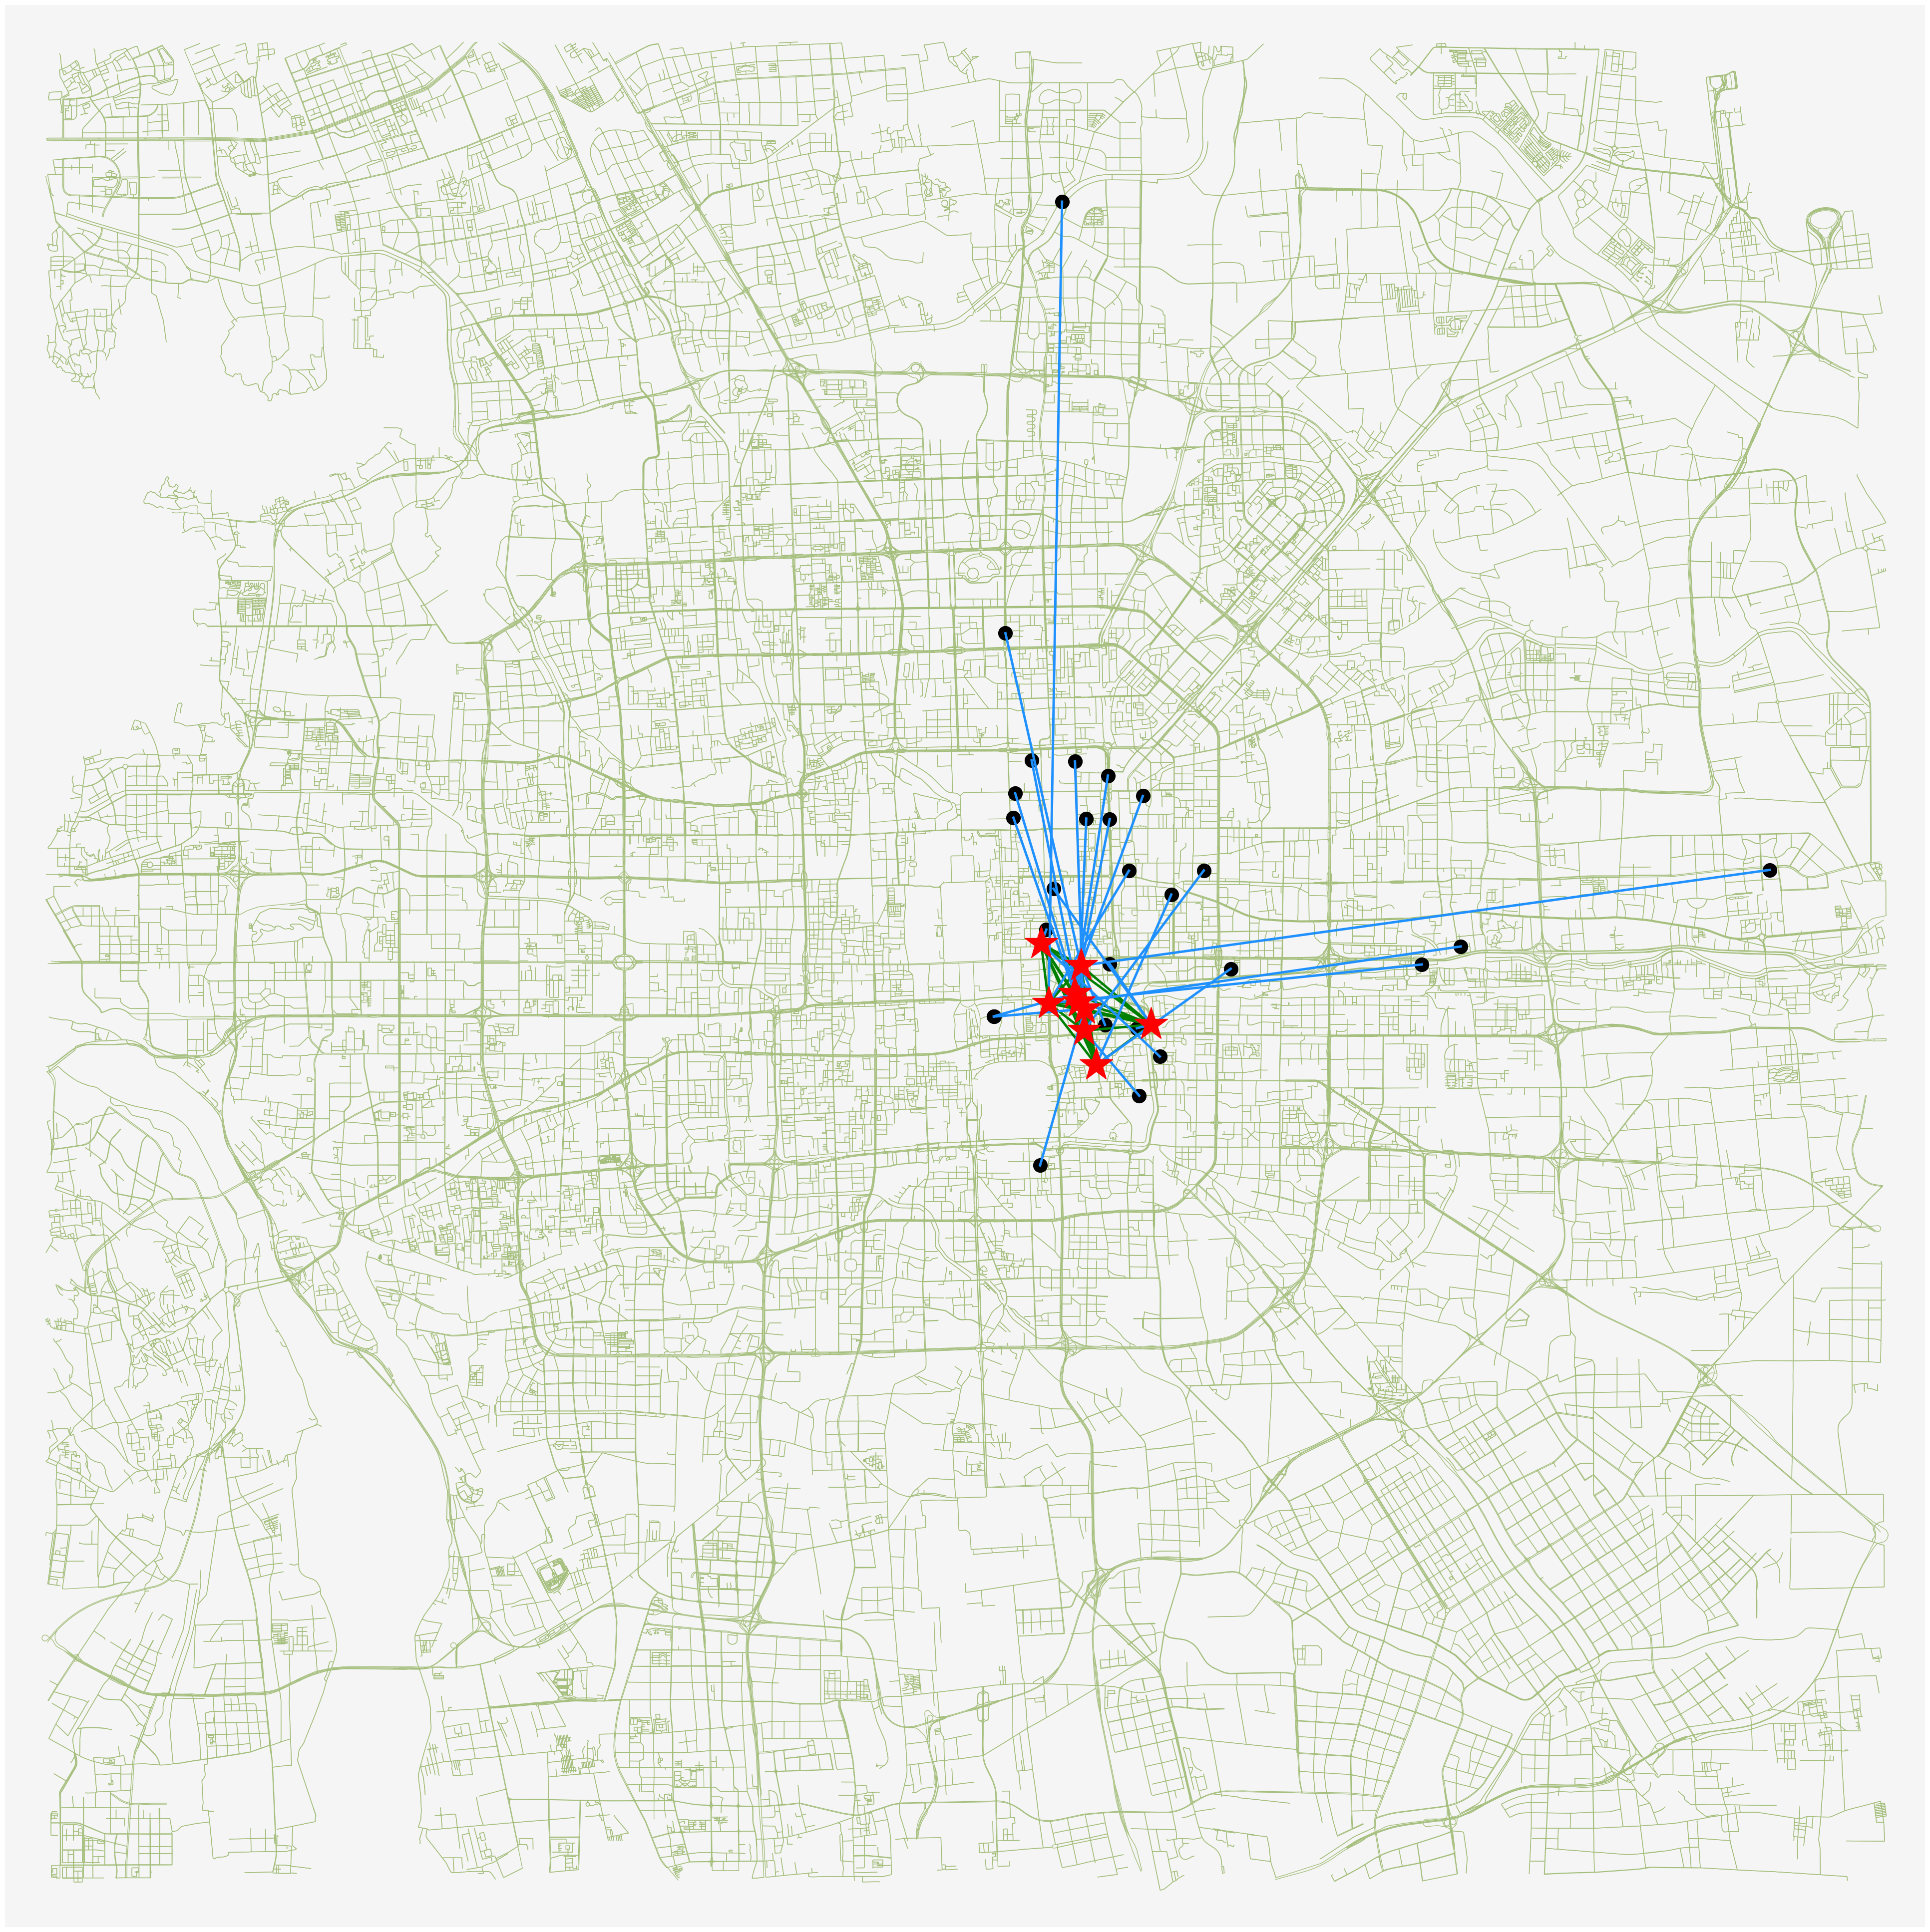

In [22]:
G = ox.load_graphml('..\data\Beijing.graphml')
ox.plot_graph(G, figsize=(50,50),bgcolor="#F5F5F5",node_size=0,edge_color = "#A4BE7B", show=False, close=False)
for j in range(num_points):
    if j in selected:
        lx = df['lat'][j]
        ly = df['long'][j]
        plt.plot(ly,lx,c='red',marker='*',markersize=50, zorder=3)
    else:
        lx = df['lat'][j]
        ly = df['long'][j]
        plt.plot(ly,lx,c="black",marker='o',markersize=20, zorder=2)

N = list(range(len(X)))
H = list(set(A))
for k1 in range(len(H)):
    for k2 in range(k1, len(H)):
        i = H[k1]
        j = H[k2]
        plt.plot([Y[i], Y[j]], [X[i], X[j]], color='g', linewidth=3.5)
for i in set(N) - set(H):
    plt.plot([Y[i], Y[A[i]]], [X[i], X[A[i]]], color='#1E90FF', linewidth=3.5)